# KWS20 Audio Evaluation and Inference Test
With this notebook, you can evaluate a KWS quantized checkpoint using .wav audio files or .npy sample data.
You need the trained model and the quantized checkpoint. A recorded 16khz mono .wav file can be used as the input.
It can also mix a clean audio file with background noise at different SNR levels and evaluate the inference result.

To play the audio files, you need to install sounddevice:

$pip3 install sounddevice

In [1]:
###################################################################################################
#
# Copyright (C) 2022-2023 Maxim Integrated Products, Inc. All Rights Reserved.
#
# Maxim Integrated Products, Inc. Default Copyright Notice:
# https://www.maximintegrated.com/en/aboutus/legal/copyrights.html
#
###################################################################################################

import os
import sys

import numpy as np
import torch

import matplotlib.pyplot as plt

import scipy.io.wavfile as wav

import importlib
import librosa
import soundfile as sf
import sounddevice as sd  # If you need to install: $pip3 install sounddevice

from IPython.display import clear_output

sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '../models/'))

import ai8x

 Specify the quantized checkpoint and model to import.
 
 Enter your own model file name to import (e.g. 'ai85net-kws21-v3.py'):

In [2]:
trained_checkpoint_path = os.path.join("..", "..", "ai8x-synthesis", "trained", "ai85-kws20_v3-qat8-q.pth.tar")
mod = importlib.import_module("ai85net-kws20-v3")

Define the ordered list of classes:

In [3]:
classes = ['up', 'down', 'left', 'right', 'stop', 'go', 'yes', 'no', 'on', 'off', 'one',
           'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'zero', 'unknown']

Now, let's define some functions to help with the evaluation:

# A) Functions to mix audio with noise at different SNRs
Use add_noise with a signal and a noise .wav file to generate a series of mixed audio files with different SNRs. 

The snr_mixer2() combines the clean audio with the noise.

In [4]:
def snr_mixer2(clean, noise, snr):
    """
    Mix clean and noise with provided SNR level.
    """
    eps = 1e-8
    s_pwr = np.var(clean)
    noise = noise - np.mean(noise)
    n_var = s_pwr / (10**(snr / 10))
    noise = np.sqrt(n_var) * noise / (np.std(noise) + eps)
    noisyspeech = clean + noise

    if max(abs(noisyspeech)) > 1:
        noisyspeech /= max(abs(noisyspeech))
    return noisyspeech

In [5]:
def add_noise(signal_file, noise_file, out_folder='Mixed_SNR', snr_low=-5, snr_high=20):
    """
    Mix an audio file with background noise for the provided range of SNR levels and copy them to out_folder.
    """
    sample_rate = 16384
    
    noise, noise_samplerate = librosa.load(os.path.join('', noise_file),
                                           sr=sample_rate)
    signal, signal_samplerate = librosa.load(os.path.join('', signal_file),
                                             sr=sample_rate)

    # make the noise size the same as signal
    noise_concat = noise
    while len(signal) > len(noise_concat):
        noise_concat = np.concatenate((noise_concat, noise), axis=0)

    noise_concat = noise_concat[:len(signal)]

    try:
        os.makedirs(out_folder)
    except:
        pass

    for db in range(snr_low, snr_high, 1):
        noisy = snr_mixer2(signal, noise_concat, db)
        # sd.play(noisy, 16384)
        print(f'mixing {signal_file} and {noise_file} at {db}db          ', end='\r')
        sf.write(os.path.join(out_folder, os.path.basename(signal_file)[:-4] + "_SNR_" + str(db) + "db.wav"),
                 noisy, sample_rate)

# B) Functions to quantize, evaluate and run accuracy tests
These helper functions are used to quantize, evaluate and run the accuracy test for a series of mixed audio & noise files:

In [6]:
def quantize_audio(data, num_bits=8, compand=False, mu=10):
    """
    Quantize audio
    """
    step_size = 2.0 / 2**num_bits
    max_val = 2**num_bits - 1
    q_data = np.round((data - (-1.0)) / step_size)
    q_data = np.clip(q_data, 0, max_val)
    return np.uint8(q_data)

In [7]:
def softmax_2(x):
    """
    Softmax implementation similar to izer: y_i = 2^(x_i/16384) / sum(2^(x_j/16384))
    """
    bx = np.power(2, x/16384)
    sm = bx.sum(axis=0)
    return bx / sm

In [8]:
def evaluate(fname, index=0, scale=1, play=True, plot=True):
    """
    Evaluate a 16khz sampled .wav file, or a sample_data.npy.
    fname: .wav or .npy file
    index: Specify a sample index to start inference from
    scale: If needed, scale samples by the specified value 
    play: True to play the audio
    plot: True to plot
    """
    if fname[len(fname)-3:] == "npy":
        samples = torch.tensor(np.load(fname), dtype=torch.float)

        # In case it is a npy file that is 1-d, make it 2-d 128x128
        if samples.shape[0] == 128*128:  # convert to 128x128
            samples_128 = np.zeros((128, 128)).astype("float32")
            for k in range(128):
                for j in range(128):
                    samples_128[j, k] = samples[k*128 + j]
            samples = torch.from_numpy(samples_128)
    else:
        (rate, sig) = wav.read(os.path.join(fname))
        sig = scale*sig[index:index+16384]
        # print(f'Rate: {rate}, Len: {len(sig)}')
        if play:
            sd.play(sig, rate)
        sig = np.pad(sig, [0, 16384-sig.size])
        
        sig_q = quantize_audio(sig/(2*max(sig)))  # double the magnitude

        samples = np.zeros((128, 128)).astype("float32")
        for k in range(128):
            for j in range(128):
                samples[j, k] = sig_q[k*128 + j]
        samples = torch.from_numpy(samples) - 128.0
      
    # print(f' Shape: {samples.shape}, Min: {samples.min()}, Max: {samples.max()}')   
    sample_in = torch.unsqueeze(samples, 0)
    
    # evaluate
    model.eval()
    out = model(sample_in)
    # print(out)

    # find the detected class
    out_vals = np.argmax(out[0, :].detach().cpu().numpy(), axis=0)

    # softmax for confidence
    conf = softmax_2(out[0, :].detach().numpy())
    conf = int(100*conf[out_vals])
    
    if plot:
        plt.title(classes[out_vals].upper() + "(" + str(conf) + "%)")
        plt.plot(np.transpose(samples).flatten())
        plt.show()
    
    # print(f'Class: {out_vals} ({classes[out_vals].upper()})')
    # print(f'Confidence: {conf}%')
    
    return out_vals, conf

In [9]:
def find_accuracy_audio(index_list, expected_output_list, audio_file_name):
    """
    Evaluate a 16khz samples .wav file, or a sample_data.npy.
    index_list: the list of sample index for each uttered word in the audio_file
    expected_output_list: the list of expected classes for uttered words in the audio_file
    """
    right = 0
    right_conf = 0.0
    for k in range(0, len(index_list)):  
        cl,co = evaluate(audio_file_name, index_list[k], scale=1, play=False, plot=False)
        #  print(cl,co)
        if expected_output_list[k] == cl:
            right += 1
            right_conf += co
        k += 1
        # clear_output(wait=True)
    if right != 0:
        right_conf = right_conf/right
    # print(f'SNR: {snr}, Total correct: {right}/{i}, avg_conf: {right_conf}')
    return right/k, right_conf

In [10]:
def run_accuracy_test(index_list, class_list, input_folder, snr_low=-5, snr_high=25):
    """
    Run accuracy test by evaluating all 16khz mixed signal and noise files generated by
    add_noise function. Each file name ends with "_snrvalue" followed by "db.wav".
    index_list: the list of sample index for each uttered word in the audio_file
    class_list: the elist of xpected classes for uttered words in the audio_file
    input_folder: folder with all audio files
    """
    snr = np.zeros(snr_high - snr_low)
    accuracy = np.zeros(snr_high - snr_low)
    conf = np.zeros(snr_high - snr_low)
    n = 0 
    for n, k in enumerate(range(snr_low, snr_high)):
        snr[n] = k 
        for (dirpath, dirnames, filenames) in os.walk(os.path.join("", input_folder)):
            for filename in sorted(filenames):
                # print(filename)
                if filename.endswith("_" + str(k) + "db.wav"):
                    # print(dirpath)
                    accuracy[n], conf[n] = find_accuracy_audio(index_list, class_list, os.path.join(dirpath, filename))
                    print(f'{filename}: Accuracy: {accuracy[n]*100}%, Avg Conf: {conf[n]}')
    return snr[0:n], accuracy[0:n]

In [11]:
def find_far_frr_audio(index_list, expected_output_list, audio_file_name, threshold=50):
    """
    Finds False Acceptance Rate and False Rejection Rate on an audio file with multiple utterances.
    index_list: the list of sample index for each uttered word in the audio file
    expected_output_list: the list of expected classes for uttered words in the audio file
    audio_file: .wav audio file
    threshold: acceptance threshold(0-100)
    """
    true_accept = 0
    true_reject = 0
    false_accept = 0
    false_reject = 0
    for i in range(0, len(index_list)):  
        cl, co = evaluate(audio_file_name, index_list[i], scale=1, play=False, plot=False)
        # print(cl,co)
        
        if co >= threshold:   # Accept
            if expected_output_list[i] == cl:  # True
                true_accept += 1
            else: # False
                false_accept += 1
                
        else: # Reject
            if expected_output_list[i] == cl:  # False
                false_reject += 1
            else:
                true_reject += 1

        i += 1
    return true_accept/len(index_list), true_reject/len(index_list), \
        false_accept/len(index_list), false_reject/len(index_list)

In [12]:
def run_far_frr_test(index_list, class_list, input_folder, snr_low=-5, snr_high=25, 
                     threshold_low=50, threshold_high=100, threshold_step=1):
    """
    Run FAR and FRR test on all files in a folder.
    index_list: the list of sample index for each uttered word in the audio files. It should be the same for all audio files.
    class_list: the list of expected classes for uttered words in the audio files It should be the same for all audio files.
    input_folder: the folder with all snr mixed files
    snr_low, snr_high: the range of snr to choose from all snr mixed files
    threshold_low, threshold_high, threshold_step: the range and step to scan the acceptance threshold
    """

    thr = np.zeros(1 + (threshold_high - threshold_low)//threshold_step)
    far = np.zeros(1 + (threshold_high - threshold_low)//threshold_step)
    frr = np.zeros(1 + (threshold_high - threshold_low)//threshold_step)
    tar = np.zeros(1 + (threshold_high - threshold_low)//threshold_step)
    trr = np.zeros(1 + (threshold_high - threshold_low)//threshold_step)
  
    cnt = 0
    n = 0
    for k in range(snr_low, snr_high):
        for (dirpath, dirnames, filenames) in os.walk(os.path.join("", input_folder)):
            for filename in sorted(filenames):              
                if filename.endswith("_" + str(k) + "db.wav"):
                    for n, t in enumerate(range(threshold_low, threshold_high, threshold_step)):
                        print(f'{dirpath} {filename} Threshold = {t}          ', end='\r')
                        tar_val, trr_val, far_val, frr_val = find_far_frr_audio(index_list, class_list, 
                                                                os.path.join(dirpath, filename), t)
                        cnt += 1
                        thr[n] = t
                        far[n] += far_val
                        frr[n] += frr_val

                        tar[n] += tar_val
                        trr[n] += trr_val
                        # clear_output(wait=True)
    return thr[0:n+1], far[0:n+1]/cnt, frr[0:n+1]/cnt, tar[0:n+1]/cnt, trr[0:n+1]/cnt

# Step 1: Generate mixed audio and noise
In this step, we mix an audio file with multiple utterances with a background noise file with the defined SNR range. They both should be .wav and will be converted to 16KHz mono .wav.

This step is only needed once. It generates noisy audio files for each SNR level and stores in the output folder. 
These files will be used to evaluate the accuracy.

In [13]:
# Signal file is a clean audio with keyword utterance, Noise file is a background audio
add_noise(signal_file=os.path.join('kws_audio', 'voice_AN_All.wav'), 
          noise_file=os.path.join('kws_audio', 'tradeshowmedium.wav'), 
          out_folder=os.path.join('kws_audio', 'Mixed_AN_All_TradeShow'),
          snr_low=-15, snr_high=25)

# Step 2: Initialize and load the model

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Working with device:", device)

ai8x.set_device(device=85, simulate=True, round_avg=False)
qat_policy = {'start_epoch': 10, 'weight_bits': 8, 'bias_bits': 8}

Working with device: cuda
Configuring device: MAX78000, simulate=True.


Make sure the name of the model in the python model file is correct here (e.g. AI85KWS20Netv3):

In [15]:
model = mod.AI85KWS20Netv3(num_classes=len(classes), num_channels=128, dimensions=(128, 1), bias=False, 
                           quantize_activation=True, weight_bits=8, bias_bits=8)

Load the quantized checkpoint:

In [16]:
checkpoint = torch.load(trained_checkpoint_path)
model.load_state_dict(checkpoint['state_dict'], strict=False)
ai8x.update_model(model)

# Step 3: Evaluate a sample data or .wav audio
Now you can run the inference on a .npy sample data (128x128 or 16384x1 samples), or a mono 16KHz .wav audio file. 
For audio files, you can specify the sample index to start the inference from (16K samples representing 1-sec audio). You can turn off the plot and audio playback.

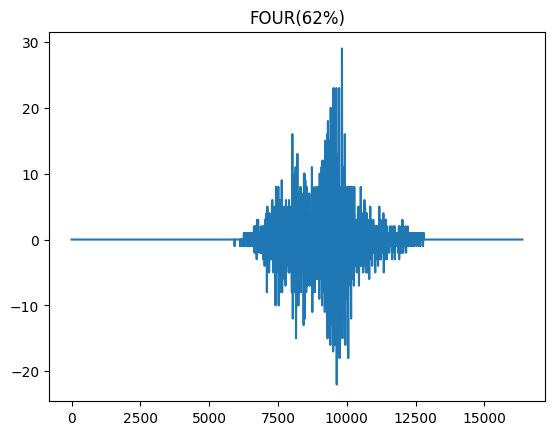

(13, 62)

In [17]:
# Evaluate the izer generated sample data
evaluate(os.path.join('..', '..', 'ai8x-synthesis', 'tests', 'sample_kws_20.npy'))

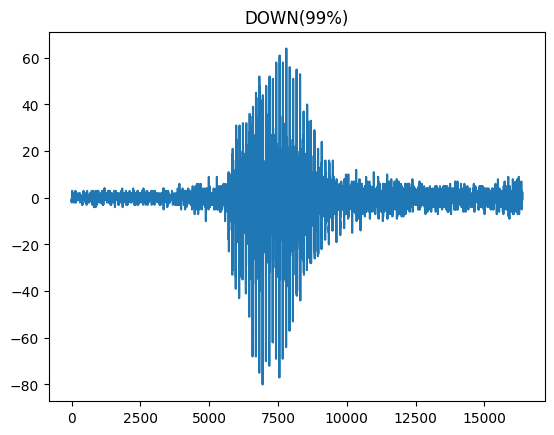

 Class: down(1), Confidence: 99%


In [18]:
# Evaluate an example audio file
audio_file = os.path.join('kws_audio', 'Mixed_AN_All_TradeShow', 'voice_AN_All_SNR_0db.wav')
class_det, confidence = evaluate(audio_file, index=30000, scale=1, plot=True, play=False)
print(f' Class: {classes[class_det]}({class_det}), Confidence: {confidence}%')

# Step 4: Run accuracy test for mixed audio files with different SNR values
In this step, it runs the accuracy test to evaluate all mixed audio files generated in step 1.

Audio files are expected to be originated from the same clean audio, mixed with different levels of background noise.

We need to know the sample index for each keyword utterance audio files, which should be the same for all.
The sample index of the beginning of each keyword and the expected keyword class for that utterance should be provided (it can be determined by listening to the clean audio at different indexes in the previous step).

In [19]:
# Index is the sample index for each utterance in the audio files (should be the same for all audio files in our test)
index_AN_ALL = [12000, 28000, 44000, 60000, 72000, 88000, 104000, 120000, 136000, 150000, 162000, 178000, 192000,
                210000, 226000, 242000, 258000, 272000, 286000, 300000]
# Expected class number for each utterance. In this example, the order is up, down, ... as defined in classes.
class_AN_ALL = range(0, 20)

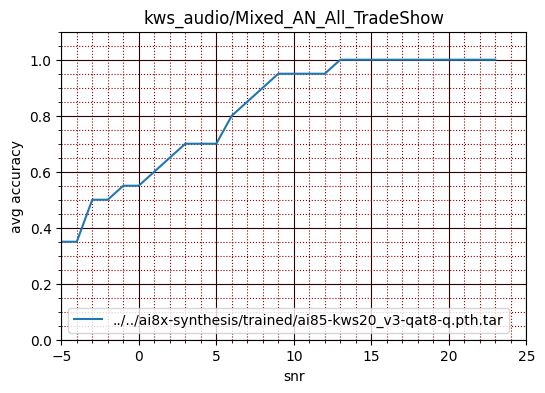

In [20]:
# Run the test. The folder with mixed audio and backgroundnoise files is specified (output folder in step 1)
audio_snr_folder = os.path.join('kws_audio', 'Mixed_AN_All_TradeShow')

# Reload a new checkpoint and model only if you want to test a different one
'''
trained_checkpoint_path = "ai85-kws20_v3-qat8-q.pth.tar"
checkpoint = torch.load(trained_checkpoint_path)
mod = importlib.import_module("ai85net-kws20-v3")
model = mod.AI85KWS20Netv3(num_classes=21, num_channels=128, dimensions=(128, 1), bias=False, quantize_activation=True,
                           weight_bits=8, bias_bits=8)
model.load_state_dict(checkpoint['state_dict'], strict=False)
ai8x.update_model(model)
'''

# Run the accuracy test on the audio files for the range of SNR values
x,y = run_accuracy_test(index_AN_ALL, class_AN_ALL, audio_snr_folder, snr_low=-15, snr_high=25)

clear_output(wait=True)

# Plot the accuracy of detecting the expected keywords in the audio files and the average confidence for all detections.
# This does not check for false detections.
f = plt.figure()
f.set_figwidth(6)
f.set_figheight(4)
plt.plot(x, y, label = trained_checkpoint_path)
plt.xlim((-5, 25))
plt.ylim((0, 1.1))
plt.xlabel('snr')
plt.ylabel('avg accuracy')
plt.title(audio_snr_folder)
plt.legend()
plt.grid(visible=True, which='major', color='#300000', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#900000', linestyle=':')
plt.show()

# Step 5: Test the acceptance threshold for FAR=FRR
In this test, we find the threshold of the confidence level to be used as the acceptance threshold such that False Acceptance Rate (FAR) equals the False Rejection Rate (FRR):


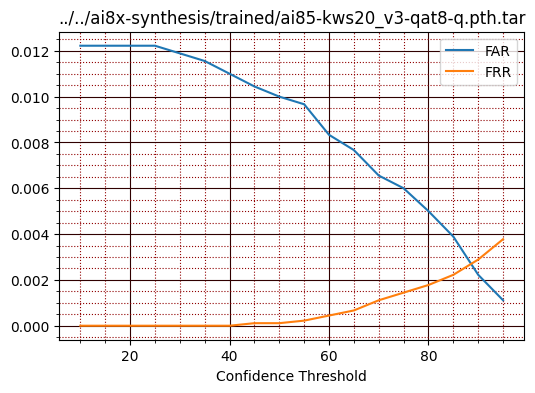

In [21]:
audio_snr_folder = os.path.join('kws_audio', 'Mixed_AN_All_TradeShow')

# Reload a new checkpoint and model only if you want to test a different one
'''
trained_checkpoint_path = "ai85-kws20_v3-qat8-q.pth.tar"
checkpoint = torch.load(trained_checkpoint_path)
mod = importlib.import_module("ai85net-kws20-v3")
model = mod.AI85KWS20Netv3(num_classes=21, num_channels=128, dimensions=(128, 1), bias=False, quantize_activation=True,
                    weight_bits=8, bias_bits=8)
model.load_state_dict(checkpoint['state_dict'], strict=False)
ai8x.update_model(model)
'''

f = plt.figure()
f.set_figwidth(6)
f.set_figheight(4)

x, y1, y2, y3, y4 = run_far_frr_test(index_AN_ALL, class_AN_ALL, os.path.join(audio_snr_folder, ''), -5, 20, 10, 100, 5)
clear_output(wait=True)
plt.plot(x, y1, label='FAR')
plt.plot(x, y2, label='FRR')
# plt.plot(x, y3, label='TAR')
# plt.plot(x, y4, label='TRR')
plt.xlabel('Confidence Threshold')
# plt.ylabel('Rate')
plt.title(trained_checkpoint_path)
plt.legend()
plt.grid(visible=True, which='major', color='#300000', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#900000', linestyle=':')
plt.show()